In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

cycle_year = '2020'
data = pd.read_csv("../data cleaning/FEC-itoth-" + cycle_year + "cycle-ctc-inkind.csv", sep='|')

In [2]:
data.head()
data.shape

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI   IMAGE_NUM TRANSACTION_TP  \
0  C00551853         N     YE           P2020    60840914            24Z   
1  C00034470         N    M11           P2020 -1529590890            24Z   
2  C00497917         N    M11           P2020  1355307213            24Z   
3  C00369058         A    M12           P2020   643113290            24Z   
4  C00516526         N     YE           P2020    60834003            24Z   

  ENTITY_TP                        NAME         CITY STATE  ...  OCCUPATION  \
0       CCM  MCCONNELL SENATE COMMITTEE   LOUISVILLE    KY  ...         NaN   
1       CCM         PETERS FOR MICHIGAN   WASHINGTON    DC  ...         NaN   
2       CCM    CAPITO FOR WEST VIRGINIA   CHARLESTON    WV  ...         NaN   
3       ORG                       MENUS  WASHINGTONI    DC  ...         NaN   
4       CCM             TEAM GRAHAM INC     COLUMBIA    SC  ...         NaN   

   TRANSACTION_DT  TRANSACTION_AMT   OTHER_ID       TRAN_ID FILE_NUM MEMO_CD  \
0        11102017           1583.0  C00193342    SB23.I7739  1203180       X   
1        10192017            357.0  C00437889  SB23.29050.3  1191803       X   
2        10092017            650.0  C00539825  SB23.24249.0  1191713       X   
3        11302017            840.0  C00196774    SB23.17448  1195973     NaN   
4        07282017            300.0  C00458828   SB23.6683.0  1203104       X   

   MEMO_TEXT               SUB_ID amt_firstdig  
0        NaN  4020720181504117798            1  
1        NaN  4112020171465725303            3  
2        NaN  4112020171465720523            6  
3        NaN  4010520181499866514            8  
4        NaN  4020620181503872629            3  

[5 rows x 22 columns]

(4592, 22)

In [3]:
data['TRANSACTION_AMT'].describe()
first_digits = data['amt_firstdig']

count      4592.000000
mean       2494.887413
std       14561.837923
min           1.000000
25%          49.000000
50%         154.000000
75%         900.000000
max      513087.000000
Name: TRANSACTION_AMT, dtype: float64

<AxesSubplot:>

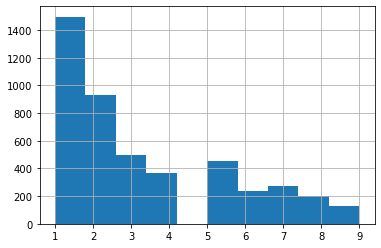

In [4]:
# Now I need to report the frequencies of each of the amt_first digits
# First, get the counts of each digit from 0 through 9
first_digits.hist()
# I wish I could get the histogram for Benford's law data

In [5]:
first_digit_counts = first_digits.value_counts().sort_index()
first_digit_counts
first_digit_counts.keys()

1    1497
2     933
3     500
4     370
5     451
6     239
7     271
8     204
9     127
Name: amt_firstdig, dtype: int64

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [6]:
# Now get the total number of rows
total_rows = len(data)
first_digit_freq = first_digit_counts/total_rows

In [7]:
# Create Benford's limiting order distribution as a series
benfordd = pd.Series([0.30103,0.17609, 0.12494, 0.09691, 0.07918, 0.06995, 0.05799, 0.05115, 0.04576], index=range(1,10))

# [Goodness of Fit Tests](https://www.statisticshowto.com/goodness-of-fit-test/)
## [Chi-Squared Test](https://www.statisticshowto.com/probability-and-statistics/chi-square/)
First, I need to use the total number of rows to calculate the expected number of counts for each digit from Benford's distribution (expected) and compare it to first_digit_counts (observed).
The null hypothesis is that the 2018 cycle campaign finance data does follow Benford's distribution. <br>
The alternative hypothesis is that the 2018 cycle campaign finance data does not follow Benford's distributino.

In [8]:
import scipy.stats as stats

In [9]:
nrows = data.shape[0]
expected = benfordd*nrows

In [10]:
# source: https://stackoverflow.com/questions/27663924/printing-2-evenly-populated-lists-side-by-side-evenly/27663989
fmt = '{:<8}{:<20}{}'

print(fmt.format('', 'Expected', 'Observed'))
for i, (ben, cyc) in enumerate(zip(expected, first_digit_counts)):
    print(fmt.format(i, ben, cyc))

        Expected            Observed
0       1382.32976          1497
1       808.60528           933
2       573.72448           500
3       445.01072           370
4       363.59456           451
5       321.2104            239
6       266.29008           271
7       234.8808            204
8       210.12992           127


In [11]:
stats.chisquare(f_obs=first_digit_counts, f_exp=expected)

Power_divergenceResult(statistic=129.8496076753457, pvalue=3.0395826195160373e-24)

The Chi-squared statistic is 63.98 and the corresponding p-value is 7.65e-11 (basically zero). Since the p-value is less than 0.05, we reject the null hypothesis and claim that the 2018 cycle data do not follow Benford's distribution.
I need to come back and double check this!! It's very odd that the p-value is low when it appears to fit Benford's distribution so well. I should read stats.chisquare documentation more, check that my degrees of freedom are correct, and/or look at [this post](https://stackoverflow.com/questions/42888962/chi-squared-goodness-of-fit-test-in-python-way-too-low-p-values-but-the-fittin) <br>
Ahh, I should come back to it after I have all the proper data. According to Cho & Gaines on p. 220 "$\chi^2$ tests are very sensitive to sample size, having enormous power for large *N*, so that even quite small differences will be statistically significant. This test appears to be too rigid to assess goodness-of-fit well, especially since the Benford proportions do not represent a true distribution that one would expect to occur in the limit (Ley 1996; Giles 2007)."

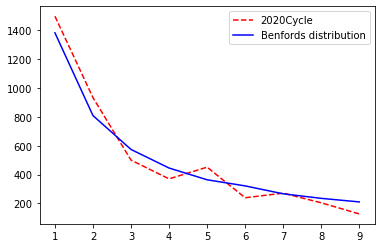

In [12]:
fig, ax = plt.subplots()
ax.plot(first_digit_counts, '--r', label= cycle_year + 'Cycle')
ax.plot(expected, '-b', label='Benford''s distribution')
leg = ax.legend()

Graphically the 2020 election cycle looks somewhat close to Benford's law, but there does seem to be some deviation around 3, 4, and 6 being less frequent relatively and 5 being more frequent relatively - hard to say if these are actually significant differences though.

In [13]:
first_digit_freq

1    0.326002
2    0.203179
3    0.108885
4    0.080575
5    0.098214
6    0.052047
7    0.059016
8    0.044425
9    0.027657
Name: amt_firstdig, dtype: float64